<a href="https://colab.research.google.com/github/r2nery/lamfo-glove/blob/main/glove_word2vec_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Dependencies

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import os

from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [63]:
%cd gdrive/My Drive/LAMFO/lamfo-glove

[Errno 2] No such file or directory: 'gdrive/My Drive/LAMFO/lamfo-glove'
/content/gdrive/My Drive/LAMFO/lamfo-glove


In [64]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Sarcasm Detection

## Loading data

In [65]:
df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  
0  https://www.theonion.com/thirtysomething-scien...  
1  https://www.huffingtonpost.com/entry/donna-edw...  
2  https://www.huffingtonpost.com/entry/eat-your-...  
3  https://local.theonion.com/inclement-weather-p...  
4  https://www.theonion.com/mother-comes-pretty-c...

## Data cleaning

In [66]:
df.isna().sum() # Checking for NaN values

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [67]:
del df['article_link'] # Deleting this column as it is of no use

In [68]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [69]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

## Basic EDA

### Data balance

In [70]:
df.head()

is_sarcastic                                           headline
0             1  thirtysomething scientists unveil doomsday clo...
1             0  dem rep. totally nails congress falling short ...
2             0       eat veggies: 9 deliciously different recipes
3             1       inclement weather prevents liar getting work
4             1  mother comes pretty close using word 'streamin...

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


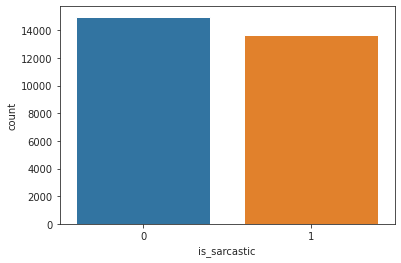

In [71]:
sns.set_style("ticks")
sns.countplot(df.is_sarcastic)
plt.savefig('sarcastic_count.png', dpi=300)

### Wordcloud: not sarcastic text

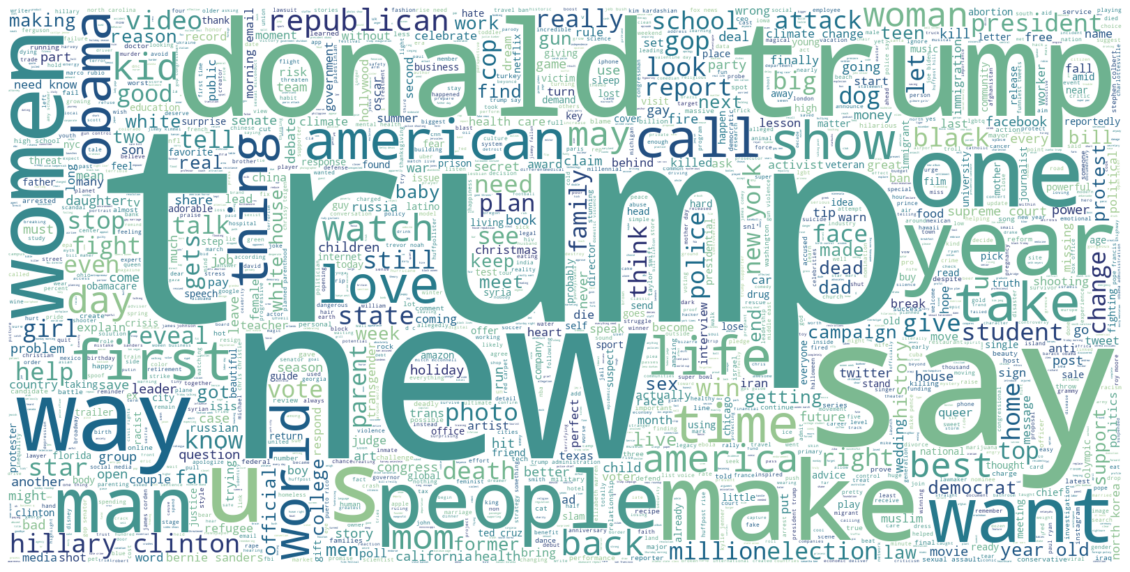

In [72]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800, colormap = "crest",background_color='white',stopwords = STOPWORDS).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.axis("off")
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('wordcloud_not_sarcastic.png', dpi=600)

### Wordcloud: sarcastic text

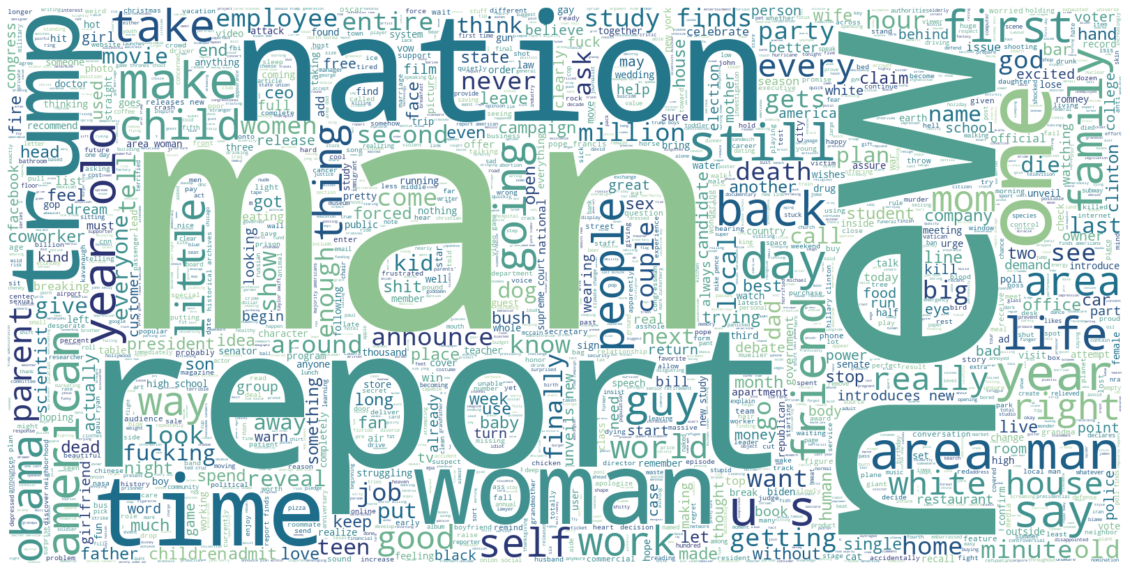

In [73]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800, colormap = "crest",background_color='white',stopwords = STOPWORDS).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.axis("off")
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('wordcloud_sarcastic.png', dpi=600)

### Number of characters in each text

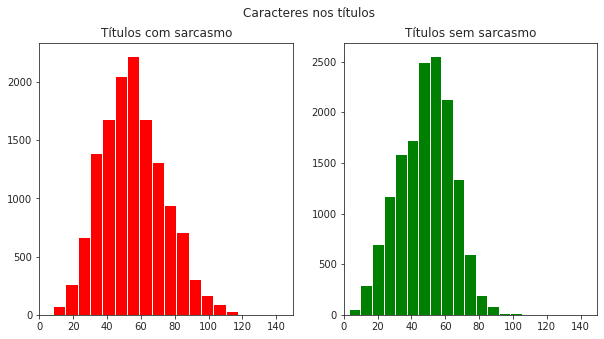

<Figure size 432x288 with 0 Axes>

In [100]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red',bins=100)
ax1.set_title('Títulos com sarcasmo')
ax1.set(xlim=(0, 150))
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green',bins=23)
ax2.set_title('Títulos sem sarcasmo')
ax2.set(xlim=(0, 150))
fig.suptitle('Caracteres nos títulos')
plt.show()
plt.savefig('charcount_sarcastic.png', dpi=600)

### Number of words in each text

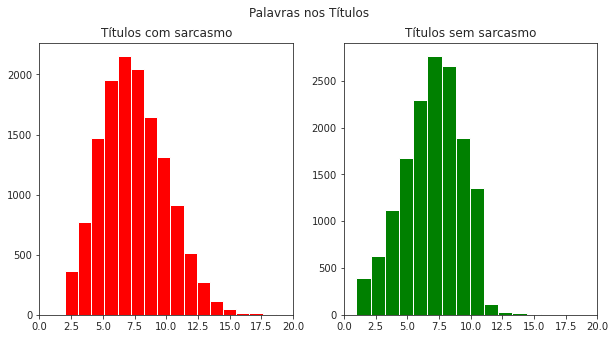

<Figure size 432x288 with 0 Axes>

In [96]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red',bins=100)
ax1.set_title('Títulos com sarcasmo')
ax1.set(xlim=(0, 20))
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green',bins=17)
ax2.set_title('Títulos sem sarcasmo')
ax2.set(xlim=(0, 20))
fig.suptitle('Palavras nos Títulos')
plt.show()
plt.savefig('wordcount_sarcastic.png', dpi=600)

### Average word length in a text

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


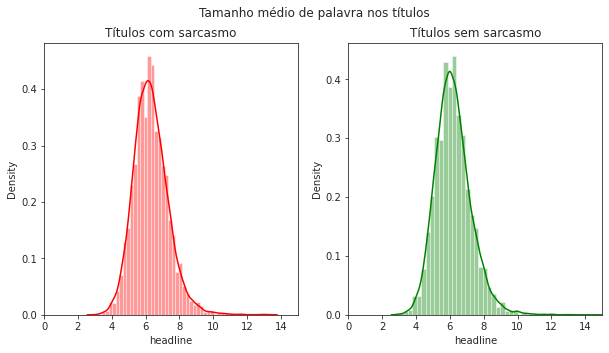

In [76]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Títulos com sarcasmo')
ax1.set(xlim=(0, 15))
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Títulos sem sarcasmo')
ax2.set(xlim=(0, 15))
fig.suptitle('Tamanho médio de palavra nos títulos')
plt.savefig('avgwlength_sarcastic.png', dpi=600)

## Word2Vec

### Converting text to format acceptable by gensim

In [77]:
words = []
for i in df.headline.values:
    words.append(i.split())

In [78]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 200

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [79]:
#vocab size
len(w2v_model.wv.vocab)
#We have now represented each of 38071 words by a 100dim vector.

38071

In [80]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [81]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [82]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [83]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


### Model parameters

In [84]:
batch_size = 256
epochs = 5
embed_size = 200
input_length = 200

In [85]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

### Training word2vec

In [86]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=input_length, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [87]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          7614400   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 256)         336896    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               55680     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 8,007,041
Trainable params: 8,007,041
Non-trainable params: 0
_________________________________________________________________


In [88]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [89]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (x_test,y_test) , epochs = epochs)

Epoch 1/5


ValueError: ignored

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

### Training Analysis

#### Accuracy & Loss

In [ ]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

Seems like the model is overfitting and performing poorly on the data

#### Classification report

In [ ]:
pred = (model.predict(x_test) > 0.5).astype("int32")
pred[:5]

In [ ]:
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))

#### Confusion matrix

In [ ]:
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Greens", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])
plt.savefig('confusion_w2v_sarcastic.png', dpi=600)

## GloVe

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(df.headline,df.is_sarcastic, test_size = 0.3 , random_state = 0)

In [ ]:
max_features = 35000
maxlen = 200

Tokenizing, padding/truncating, word mapping is kept

In [ ]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
EMBEDDING_FILE = 'glove.twitter.27B.200d.txt'
#EMBEDDING_FILE = 'glove.42B.300d.txt'

In [ ]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

#### Model parameters

In [ ]:
batch_size = 256
epochs = 5
embed_size = 200
input_length = 200

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

### Training GloVe

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], input_length= input_length, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], input_length=input_length, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs, callbacks = [learning_rate_reduction])

In [ ]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

### Training Analysis

#### Accuracy & Loss

#### Classification report

In [ ]:
pred = (model.predict(X_test) > 0.5).astype("int32")
pred[:5]


In [ ]:
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))

#### Confusion matrix

In [ ]:
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])
plt.savefig('confusion_glove_sarcastic.png', dpi=600)

# Fake News Detection

## Loading data

In [102]:
true = pd.read_csv("True.csv")
false = pd.read_csv("Fake.csv")

## Data cleaning

In [103]:
true['is_fake'] = 0
false['is_fake'] = 1

In [104]:
df = pd.concat([true,false])

In [105]:
df.isna().sum() # Checking for nan Values

title      0
text       0
subject    0
date       0
is_fake    0
dtype: int64

In [106]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [107]:
df['text']=df['text'].apply(denoise_text)

## Basic EDA

### Data balance

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


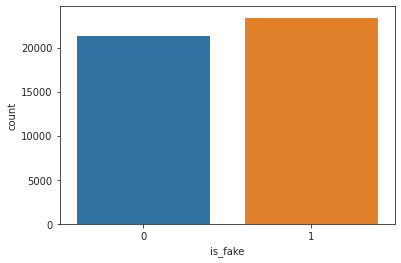

In [108]:
sns.countplot(df.is_fake)

### Wordcloud: real news

SystemError: ignored

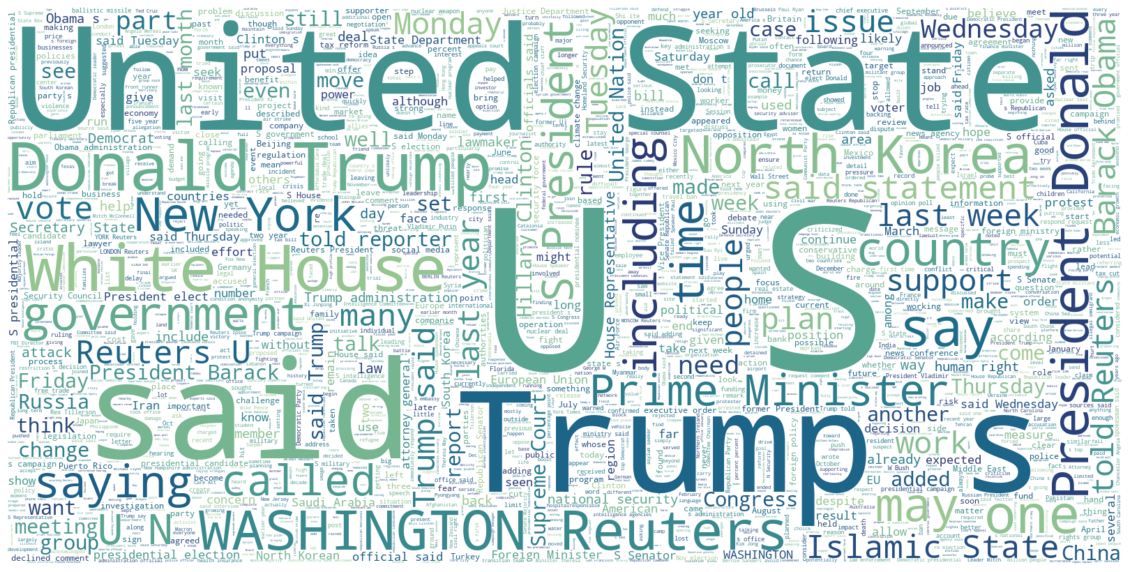

In [109]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800, colormap = "crest",background_color='white', stopwords = STOPWORDS).generate(" ".join(df[df.is_fake == 0].text))
plt.axis("off")
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('wordcloud_not_fake.png', dpi=600)

### Wordcloud: fake news

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800, colormap = "crest",background_color='white', stopwords = STOPWORDS).generate(" ".join(df[df.is_fake == 1].text))
plt.axis("off")
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('wordcloud_fake.png', dpi=600)

### Number of characters in each text

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_fake']==1]['text'].str.len()
ax1.hist(text_len,color='red', bins=100)
ax1.set_title('Notícias falsas')
ax1.set(xlim=(0, 8000))
text_len=df[df['is_fake']==0]['text'].str.len()
ax2.hist(text_len,color='green',bins=50)
ax2.set_title('Notícias verdadeiras')
ax2.set(xlim=(0, 8000))
fig.suptitle('Caracteres nos textos')
plt.show()
plt.savefig('charcount_fakenews.png', dpi=600)

### Number of words in each text

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_fake']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red',bins=100)
ax1.set_title('Notícias falsas')
ax1.set(xlim=(0, 1250))
text_len=df[df['is_fake']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green',bins=55)
ax2.set_title('Notícias verdadeiras')
ax2.set(xlim=(0, 1250))
fig.suptitle('Palavras nas notícias')
plt.show()
plt.savefig('wordcount_fakenews.png', dpi=600)

### Average word length in a text

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=df[df['is_fake']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red',bins=100)
ax1.set_title('Notícias falsas')
ax1.set(xlim=(4, 9))
word=df[df['is_fake']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green',bins=25)
ax2.set_title('Notícias verdadeiras')
ax2.set(xlim=(4, 9))
fig.suptitle('Tamanho médio de palavra nas notícias')
plt.savefig('avgwlength_fakenews.png', dpi=600)

## GloVe

In [127]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.is_fake, test_size = 0.3 , random_state = 0)

In [128]:
max_features = 35000
maxlen = 200

Tokenizing, padding/truncating, word mapping is kept

In [129]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [130]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [131]:
EMBEDDING_FILE = 'glove.twitter.27B.200d.txt'
#EMBEDDING_FILE = 'glove.42B.300d.txt'

In [132]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [133]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


#### Model parameters

In [134]:
batch_size = 256
epochs = 5
embed_size = 200
input_length = 200

In [135]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

### Training GloVe

In [136]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], input_length= input_length, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], input_length=input_length, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

In [137]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 200)          7000000   
                                                                 
 lstm_1 (LSTM)               (None, 200, 128)          168448    
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7,219,969
Trainable params: 219,969
Non-trainable params: 7,000,000
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs, callbacks = [learning_rate_reduction])

Epoch 1/5
 21/123 [====>.........................] - ETA: 4:42 - loss: 0.4236 - accuracy: 0.8179

In [ ]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

### Training Analysis

#### Accuracy & Loss

#### Classification report

In [ ]:
pred = (model.predict(X_test) > 0.5).astype("int32")
pred[:5]


In [ ]:
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))

#### Confusion matrix

In [ ]:
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])
plt.savefig('confusion_glove_sarcastic.png', dpi=600)